In [42]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances, manhattan_distances
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

In [2]:
customers_file = '/content/Customers.csv'
products_file = '/content/Products.csv'
transactions_file = '/content/Transactions.csv'

In [3]:
# Load the datasets
customers = pd.read_csv(customers_file)
products = pd.read_csv(products_file)
transactions = pd.read_csv(transactions_file)

In [4]:
# Merge transactions with products
transactions_products = transactions.merge(products, on='ProductID')

# Merge with customers
merged_data = transactions_products.merge(customers, on='CustomerID')

# Check the resulting structure
print(merged_data.head())


  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue  Price_x                      ProductName     Category  Price_y  \
0      300.68   300.68  ComfortLiving Bluetooth Speaker  Electronics   300.68   
1      300.68   300.68  ComfortLiving Bluetooth Speaker  Electronics   300.68   
2      300.68   300.68  ComfortLiving Bluetooth Speaker  Electronics   300.68   
3      601.36   300.68  ComfortLiving Bluetooth Speaker  Electronics   300.68   
4      902.04   300.68  ComfortLiving Bluetooth Speaker  Electronics   300.68   

      CustomerName         Region  SignupDate  
0   Andrea Jenkins         Europe  202

In [43]:

def create_customer_features(merged_data):

    # Calculate customer lifetime value
    customer_ltv = merged_data.groupby('CustomerID')['TotalValue'].sum()

    # Calculate average transaction value
    customer_avg_transaction = merged_data.groupby('CustomerID')['TotalValue'].mean()

    # Calculate purchase frequency
    customer_purchase_freq = merged_data.groupby('CustomerID').size()

    # Calculate category preferences
    category_preferences = pd.crosstab(
        merged_data['CustomerID'],
        merged_data['Category'],
        values=merged_data['TotalValue'],
        aggfunc='sum',
        normalize='index'
    )

    # Calculate recency (days since last purchase)
    last_purchase_date = merged_data.groupby('CustomerID')['TransactionDate'].max()
    recency = (pd.Timestamp.now() - pd.to_datetime(last_purchase_date)).dt.days

    # Create the feature matrix
    feature_matrix = pd.DataFrame(index=merged_data['CustomerID'].unique())
    feature_matrix['customer_ltv'] = customer_ltv
    feature_matrix['avg_transaction'] = customer_avg_transaction
    feature_matrix['purchase_freq'] = customer_purchase_freq
    feature_matrix['recency'] = recency

    # Add category preferences
    feature_matrix = pd.concat([feature_matrix, category_preferences], axis=1)

    # Fill NaN values with 0
    feature_matrix = feature_matrix.fillna(0)

    return feature_matrix

In [44]:
def calculate_similarities(feature_matrix, method='cosine'):

    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(feature_matrix)

    if method == 'cosine':
        similarity_matrix = cosine_similarity(scaled_features)
    elif method == 'euclidean':
        distances = euclidean_distances(scaled_features)
        similarity_matrix = 1 / (1 + distances)
    elif method == 'manhattan':
        distances = manhattan_distances(scaled_features)
        similarity_matrix = 1 / (1 + distances)
    elif method == 'jaccard':
        binary_features = (scaled_features > scaled_features.mean(axis=0)).astype(int)
        similarity_matrix = 1 - pdist(binary_features, metric='jaccard')
        similarity_matrix = squareform(similarity_matrix)

    return pd.DataFrame(similarity_matrix, index=feature_matrix.index, columns=feature_matrix.index)


In [45]:
def get_top_n_similar(similarity_df, n=3):

    results = {}
    for customer in similarity_df.index:
        # Get similarities for this customer
        similarities = similarity_df[customer].sort_values(ascending=False)
        # Remove self-similarity
        similarities = similarities[similarities.index != customer]
        # Get top n
        top_similar = similarities.head(n)
        results[customer] = list(zip(top_similar.index, top_similar.values))
    return results

In [46]:
def evaluate_similarity_metrics(merged_data):

    methods = ['cosine', 'euclidean', 'manhattan', 'jaccard']
    feature_matrix = create_customer_features(merged_data)

    results = {}
    for method in methods:
        # Get similarity matrix
        similarity_df = calculate_similarities(feature_matrix, method=method)
        # Get top 3 similar customers for each customer
        recommendations = get_top_n_similar(similarity_df)

        # Calculate metrics
        avg_similarity = []
        region_match = []
        category_match = []

        for cust_id, lookalikes in recommendations.items():
            # Average similarity score
            scores = [score for _, score in lookalikes]
            avg_similarity.append(np.mean(scores))

            # Region matching
            cust_region = merged_data[merged_data['CustomerID'] == cust_id]['Region'].iloc[0]
            similar_regions = [merged_data[merged_data['CustomerID'] == sim_id]['Region'].iloc[0]
                             for sim_id, _ in lookalikes]
            region_match.append(np.mean([r == cust_region for r in similar_regions]))

            # Category preference matching
            cust_categories = set(merged_data[merged_data['CustomerID'] == cust_id]['Category'])
            similar_categories = [set(merged_data[merged_data['CustomerID'] == sim_id]['Category'])
                                for sim_id, _ in lookalikes]
            category_overlap = [len(cust_categories.intersection(sc)) / len(cust_categories.union(sc))
                              for sc in similar_categories]
            category_match.append(np.mean(category_overlap))

        results[method] = {
            'Average Similarity Score': np.mean(avg_similarity),
            'Region Match Rate': np.mean(region_match),
            'Category Overlap Rate': np.mean(category_match)
        }

    return pd.DataFrame(results).round(3)

,cosine,euclidean,manhattan,jaccard
Average Similarity Score,0.877,0.436,0.270,0.888
Region Match Rate,0.293,0.281,0.276,0.283
Category Overlap Rate,0.747,0.783,0.800,0.732


<Figure size 1000x600 with 0 Axes>

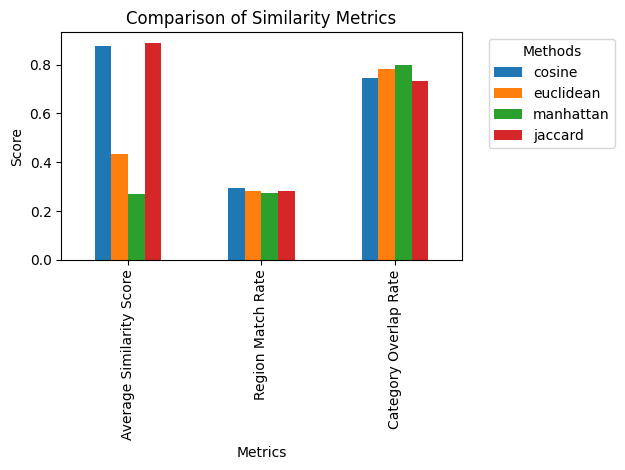

In [47]:
# Run evaluation
comparison_df = evaluate_similarity_metrics(merged_data)
display(comparison_df)

# Visualize comparison
plt.figure(figsize=(10, 6))
comparison_df.plot(kind='bar')
plt.title('Comparison of Similarity Metrics')
plt.xlabel('Metrics')
plt.ylabel('Score')
plt.legend(title='Methods', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [51]:
import pandas as pd

# Assuming the merged_data is already available from previous steps
feature_matrix = create_customer_features(merged_data)

# Calculate Jaccard similarity
similarity_df = calculate_similarities(feature_matrix, method='jaccard')

# Get top 3 most similar customers for each of the first 20 customers (C0001 to C0020)
recommendations = get_top_n_similar(similarity_df, n=3)

# List of the first 20 customers (C0001 to C0020)
top_20_customers = ['C0001', 'C0002', 'C0003', 'C0004', 'C0005', 'C0006', 'C0007', 'C0008', 'C0009', 'C0010',
                    'C0011', 'C0012', 'C0013', 'C0014', 'C0015', 'C0016', 'C0017', 'C0018', 'C0019', 'C0020']

# Create the lookalike map in the required format but limit to the first 20 customers
lookalike_map = {}
for cust_id, lookalikes in recommendations.items():
    if cust_id in top_20_customers:  # Filter to include only top 20 customers
        lookalike_map[cust_id] = [(sim_id, score) for sim_id, score in lookalikes]

# Convert the lookalike map into a DataFrame for easy export to CSV
lookalike_list = []
for cust_id, lookalikes in lookalike_map.items():
    for idx, (lookalike, score) in enumerate(lookalikes):
        lookalike_list.append([cust_id, f'Lookalike{idx+1}', lookalike, f'Score{idx+1}', score])

# Create a DataFrame
lookalike_df = pd.DataFrame(lookalike_list, columns=['CustomerID', 'Lookalike', 'LookalikeID', 'ScoreType', 'Score'])

# Pivot the DataFrame to have separate columns for Lookalike1, Score1, Lookalike2, Score2, Lookalike3, Score3
lookalike_pivot_df = lookalike_df.pivot_table(index='CustomerID', columns='Lookalike', values=['LookalikeID', 'Score'], aggfunc='first')

# Flatten the multi-index and reset the columns
lookalike_pivot_df.columns = [f'{col[0]}{col[1]}' for col in lookalike_pivot_df.columns]
lookalike_pivot_df.reset_index(inplace=True)

# Save to CSV
lookalike_pivot_df.to_csv('Lookalike.csv', index=False)

# Display the result to verify
print(lookalike_pivot_df.head())


  CustomerID LookalikeIDLookalike1 LookalikeIDLookalike2  \
0      C0001                 C0069                 C0157   
1      C0002                 C0178                 C0036   
2      C0003                 C0127                 C0085   
3      C0004                 C0075                 C0154   
4      C0005                 C0199                 C0031   

  LookalikeIDLookalike3  ScoreLookalike1  ScoreLookalike2  ScoreLookalike3  
0                 C0072             1.00         1.000000         1.000000  
1                 C0134             1.00         1.000000         1.000000  
2                 C0007             0.75         0.750000         0.750000  
3                 C0090             1.00         0.833333         0.833333  
4                 C0166             1.00         1.000000         1.000000  
